In [1]:
import json, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import defaultdict

# ===================== 설정 =====================
JSON_PATH = "/home/jy1559/Mar2025_Module/Datasets/Globo/interactions_revised_dense.json"          # <-- 데이터셋 경로
SHOW_HIST = True                 # 히스토그램 그릴지 여부
# ===============================================


def basic_stats(arr):
    arr = np.asarray(arr, dtype=float)
    return {
        "count"    : len(arr),
        "min"      : arr.min()     if len(arr) else None,
        "max"      : arr.max()     if len(arr) else None,
        "mean"     : arr.mean()    if len(arr) else None,
        "variance" : arr.var(ddof=0) if len(arr) else None,
    }

def hist_with_zoom(data, title, xlabel="gap (s)", bins=100):
    if not data:             # 빈 리스트 방지
        return
    import matplotlib.pyplot as plt
    import numpy as np

    # ── ① 전체 분포 (로그 스케일) ──────────────────
    plt.figure(figsize=(6,4))
    plt.hist(data, bins=bins, log=True)
    plt.xscale("log")                     # x축 로그
    plt.title(f"{title}  (log-x, log-y)")
    plt.xlabel(xlabel)
    plt.ylabel("freq (log)")
    plt.tight_layout()
    plt.show()

    # ── ② 상위 1% 구간 잘라낸 Zoom-in ───────────────
    p99 = np.percentile(data, 99)
    zoom_data = [x for x in data if x <= p99]   # 상위1% 제외
    plt.figure(figsize=(6,4))
    plt.hist(zoom_data, bins=bins)
    plt.title(f"{title}  (≤99th percentile)")
    plt.xlabel(xlabel)
    plt.ylabel("frequency")
    plt.tight_layout()
    plt.show()


def quick_hist(data, title, bins=100, xlabel="value"):
    if not SHOW_HIST or len(data) == 0:
        return
    plt.figure(figsize=(6, 4))
    plt.hist(data, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("frequency")
    plt.tight_layout()
    plt.show()


def analyse_dataset(json_path):
    if not os.path.exists(json_path):
        raise FileNotFoundError(f"{json_path} 경로가 없습니다.")

    with open(json_path, "r", encoding="utf-8") as f:
        raw = json.load(f)

    if "data" not in raw:
        raise KeyError("'data' 키를 찾을 수 없습니다.")

    data = raw["data"]  # {user_id: [session1, session2, ...]}

    # 컨테이너
    user_ids, sessions_per_user, inters_per_user = [], [], []
    session_lengths = []
    all_item_ids = []

    ts_first_user, inter_sess_gaps, intra_sess_gaps = [], [], []

    # ----------- 메인 루프 -----------
    for uid_str, sessions in data.items():
        uid = int(uid_str)
        user_ids.append(uid)

        sessions = sorted(sessions, key=lambda s: s[0][1])  # 첫 타임스탬프로 정렬
        sessions_per_user.append(len(sessions))
        inters_per_user.append(sum(len(s) for s in sessions))

        last_ts_prev = None
        for s_idx, sess in enumerate(sessions):
            sess = sorted(sess, key=lambda x: x[1])          # 세션 내 정렬
            session_lengths.append(len(sess))
            all_item_ids.extend([x[0] for x in sess])

            if s_idx == 0:
                ts_first_user.append(sess[0][1])             # 첫 interaction

            if last_ts_prev is not None:
                inter_sess_gaps.append(sess[0][1] - last_ts_prev)

            # intra-session gaps
            intra_sess_gaps.extend(
                [sess[i][1] - sess[i-1][1] for i in range(1, len(sess))]
            )

            last_ts_prev = sess[-1][1]

    # ----------- 요약 출력 -----------
    # 사용자 정보
    uid_np = np.array(user_ids)
    user_summary = {
        "total_users"      : len(uid_np),
        "user_id_min"      : uid_np.min(),
        "user_id_max"      : uid_np.max(),
        "missing_user_ids" : (uid_np.max() - uid_np.min() + 1) - len(uid_np),
    }

    # 아이템 정보
    item_np = np.array(all_item_ids)
    item_summary = {
        "item_id_min"      : item_np.min(),
        "item_id_max"      : item_np.max(),
        "unique_items"     : len(np.unique(item_np)),
        "missing_item_ids" : (item_np.max() - item_np.min() + 1) - len(np.unique(item_np)),
    }

    # 분포 통계
    dist_stats = {
        "sessions_per_user"   : basic_stats(sessions_per_user),
        "inters_per_user"     : basic_stats(inters_per_user),
        "session_lengths"     : basic_stats(session_lengths),
        "inter_session_gaps"  : basic_stats(inter_sess_gaps),
        "intra_session_gaps"  : basic_stats(intra_sess_gaps),
        "first_timestamp"     : basic_stats(ts_first_user),
    }

    # ----------- 결과 표시 -----------
    print("\n==== 사용자 요약 ====")
    for k, v in user_summary.items():
        print(f"{k:25}: {v}")

    print("\n==== 아이템 요약 ====")
    for k, v in item_summary.items():
        print(f"{k:25}: {v}")

    print("\n==== 분포별 기본 통계 ====")
    for name, stats in dist_stats.items():
        print(f"\n-- {name} --")
        for k, v in stats.items():
            print(f"  {k:9}: {v}")

    # ----------- 히스토그램 -----------
    hist_with_zoom(session_lengths,    "Session Length (#interactions)", xlabel="#interactions")
    hist_with_zoom(sessions_per_user,  "Sessions per User",              xlabel="#sessions")
    hist_with_zoom(inters_per_user,    "Interactions per User",          xlabel="#interactions")
    hist_with_zoom(intra_sess_gaps,    "Intra-Session Gaps (sec)",       xlabel="gap (s)")
    hist_with_zoom(inter_sess_gaps,    "Inter-Session Gaps (sec)",       xlabel="gap (s)")
    hist_with_zoom(ts_first_user,      "First Interaction Timestamp",    xlabel="time (s)")




In [2]:
def find_negative_gaps_verbose(data, top_n_preview=20):
    """
    data: raw["data"]  (user_id → [session1, session2, ...])
    반환: bad_cases 리스트
          각 원소 = dict(
              user_id, prev_idx, next_idx,
              gap, misordered, overlap, overlap_dur,
              cross_interleaved,
              prev_first, prev_last, next_first, next_last
          )
    """
    bad_cases = []

    for uid, sessions in data.items():
        # 세션을 **원본 순서 그대로** 두고 조사
        for idx in range(1, len(sessions)):
            prev_sess = sessions[idx - 1]
            next_sess = sessions[idx]

            # 각 세션 내는 시간순 정렬(정확한 first/last 산출 위해)
            prev_sess_sorted = sorted(prev_sess, key=lambda x: x[1])
            next_sess_sorted = sorted(next_sess, key=lambda x: x[1])

            prev_first = prev_sess_sorted[0][1]
            prev_last  = prev_sess_sorted[-1][1]
            next_first = next_sess_sorted[0][1]
            next_last  = next_sess_sorted[-1][1]

            gap = next_first - prev_last
            if gap >= 0:
                continue   # 정상

            misordered = next_first < prev_first
            overlap    = (not misordered)      # 순서는 맞는데 겹침 → overlap
            overlap_dur = max(0, prev_last - next_first)

            # 교차(interleaving) 판단
            cross_interleaved = False
            if overlap:
                # prev 세션에 next_first 이후 클릭 존재?
                has_prev_after_nf = any(t > next_first for _, t, *_ in prev_sess_sorted)
                # next 세션에 prev_last 이전 클릭 존재?
                has_next_before_pl = any(t < prev_last for _, t, *_ in next_sess_sorted)
                cross_interleaved = has_prev_after_nf and has_next_before_pl

            bad_cases.append({
                "user_id"          : uid,
                "prev_idx"         : idx - 1,
                "next_idx"         : idx,
                "gap"              : gap,
                "misordered"       : misordered,
                "overlap"          : overlap,
                "overlap_dur"      : overlap_dur,
                "cross_interleaved": cross_interleaved,
                "prev_first"       : prev_first,
                "prev_last"        : prev_last,
                "next_first"       : next_first,
                "next_last"        : next_last,
            })

    # --- 미리보기 출력 ---
    print(f"음수 inter-session gap 건수: {len(bad_cases)}")
    for case in bad_cases[:top_n_preview]:
        print(
            f"[user {case['user_id']}] sess{case['prev_idx']}→sess{case['next_idx']}: "
            f"gap={case['gap']:.1f}s | "
            f"misordered={case['misordered']} overlap={case['overlap']} "
            f"cross_interleaved={case['cross_interleaved']}"
        )

    return bad_cases


# ----------------- 사용 예 -----------------
with open(JSON_PATH, "r", encoding="utf-8") as f:
    raw = json.load(f)
bad_cases = find_negative_gaps_verbose(raw["data"], top_n_preview=10)


음수 inter-session gap 건수: 0



==== 사용자 요약 ====
total_users              : 322897
user_id_min              : 0
user_id_max              : 322896
missing_user_ids         : 0

==== 아이템 요약 ====
item_id_min              : 1
item_id_max              : 46033
unique_items             : 46033
missing_item_ids         : 0

==== 분포별 기본 통계 ====

-- sessions_per_user --
  count    : 322897
  min      : 1.0
  max      : 136.0
  mean     : 3.4470279996407522
  variance : 18.637305984322722

-- inters_per_user --
  count    : 322897
  min      : 2.0
  max      : 1232.0
  mean     : 9.254285422286364
  variance : 223.39291827594218

-- session_lengths --
  count    : 1113035
  min      : 1.0
  max      : 94.0
  mean     : 2.6847143171598375
  variance : 2.2539926300924935

-- inter_session_gaps --
  count    : 790138
  min      : 1800.0590000000084
  max      : 1378525.58
  mean     : 167959.5020160605
  variance : 40968892883.41356

-- intra_session_gaps --
  count    : 1875146
  min      : 0.0
  max      : 1799.9320000000298
  

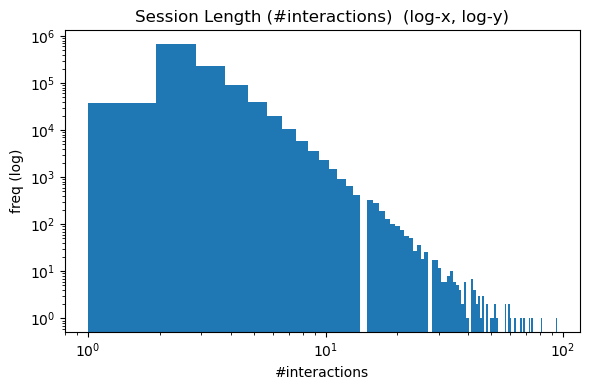

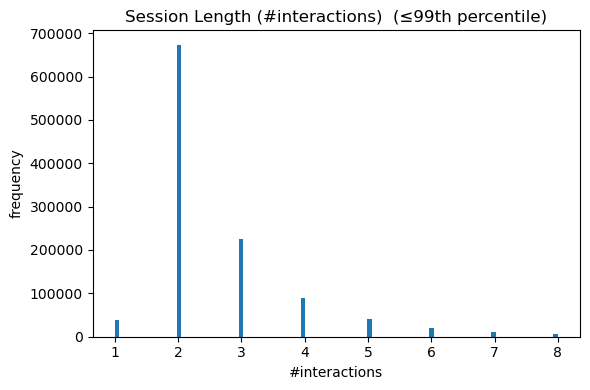

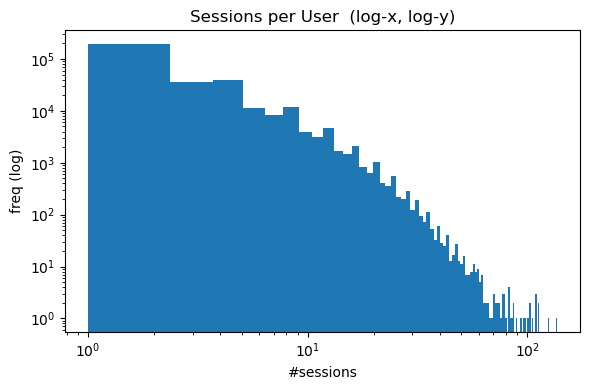

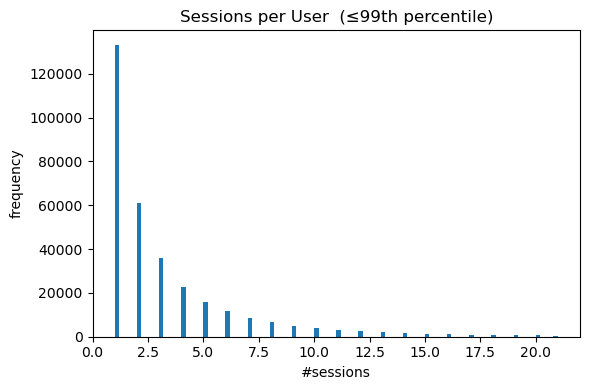

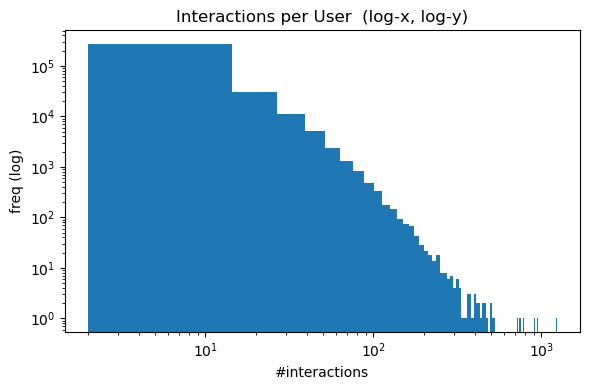

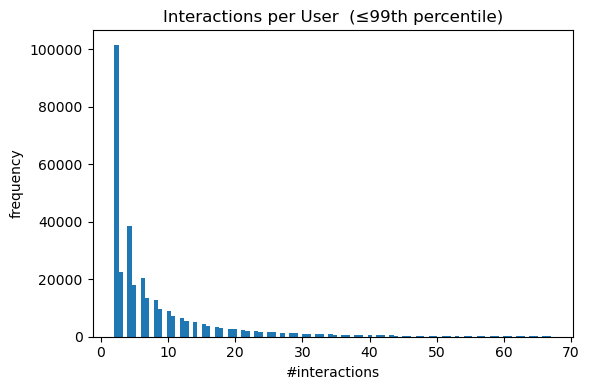

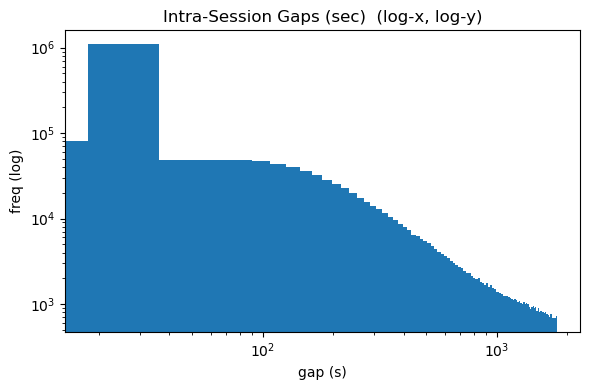

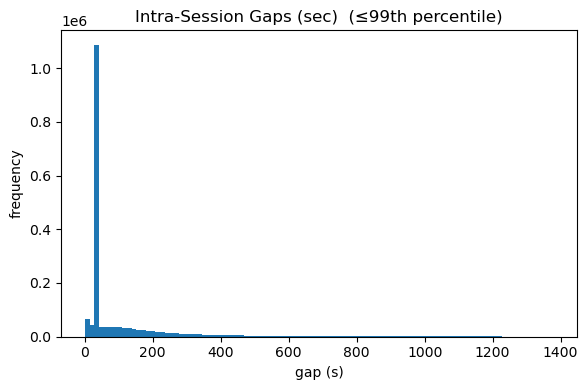

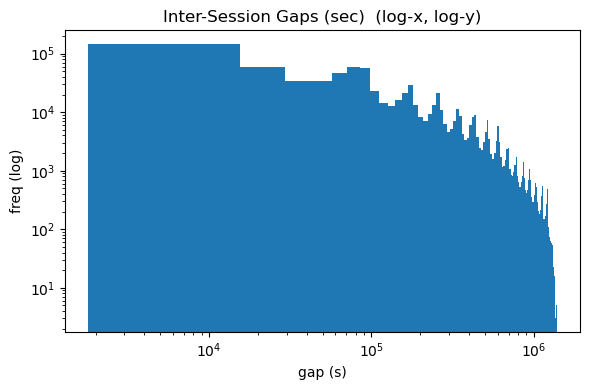

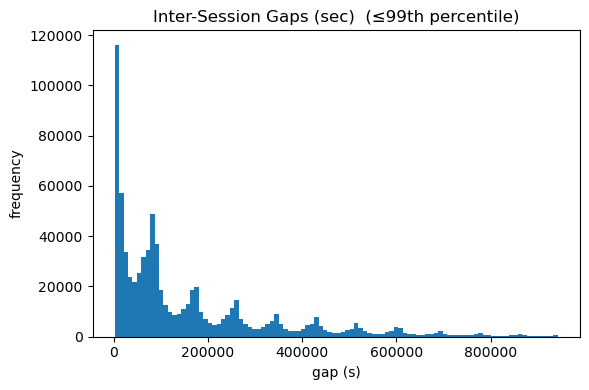

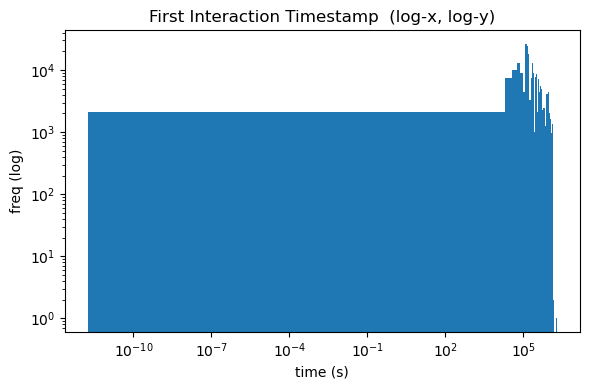

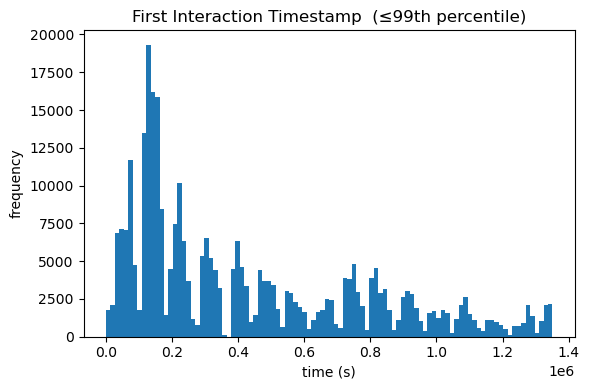

In [3]:
analyse_dataset(JSON_PATH)


==== 사용자 요약 ====
total_users              : 4148
user_id_min              : 1002693
user_id_max              : 50900118
missing_user_ids         : 49893278

==== 아이템 요약 ====
item_id_min              : 1
item_id_max              : 1084922
unique_items             : 1084922
missing_item_ids         : 0

==== 분포별 기본 통계 ====

-- sessions_per_user --
  count    : 4148
  min      : 6.0
  max      : 1915.0
  mean     : 512.3702989392478
  variance : 74080.74282083639

-- inters_per_user --
  count    : 4148
  min      : 9.0
  max      : 11177.0
  mean     : 4022.9901157184186
  variance : 3601764.4283015295

-- session_lengths --
  count    : 2125312
  min      : 1.0
  max      : 2307.0
  mean     : 7.85172388806914
  variance : 170.7131105004906

-- inter_session_gaps --
  count    : 2121164
  min      : 3600.0
  max      : 219780986.0
  mean     : 186192.76944734118
  variance : 1645384930745.544

-- intra_session_gaps --
  count    : 14562051
  min      : 1.0
  max      : 3599.0
  mean   

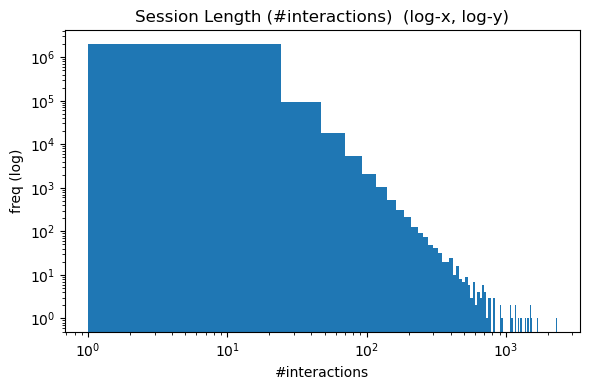

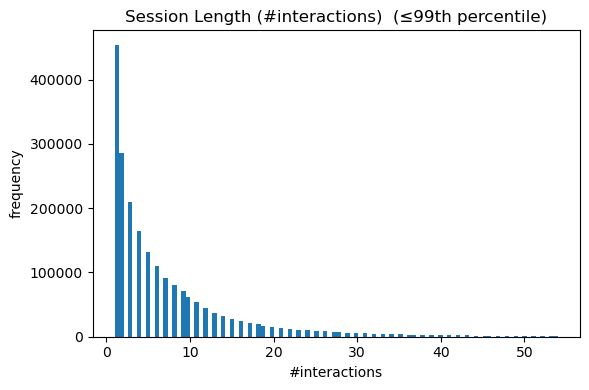

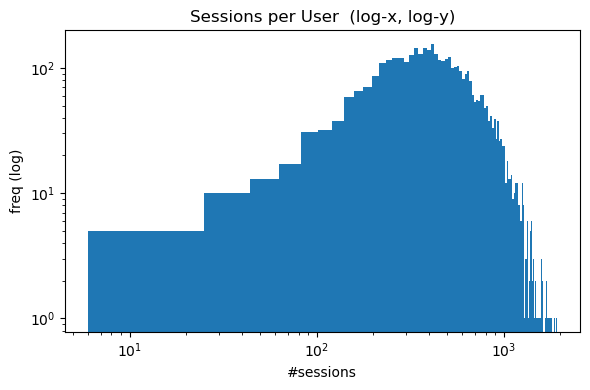

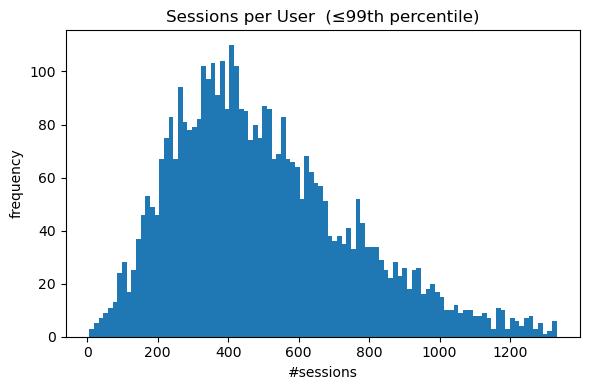

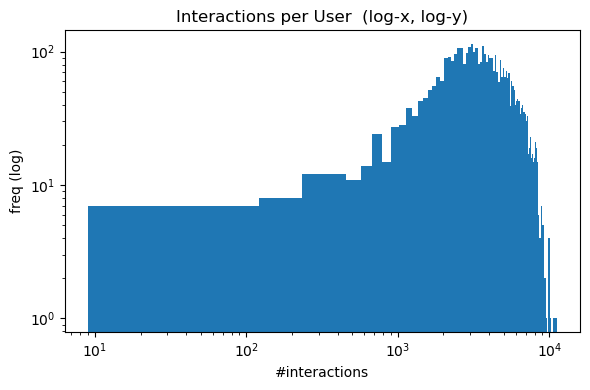

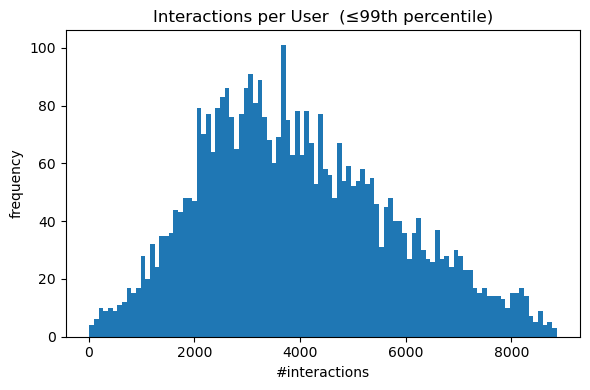

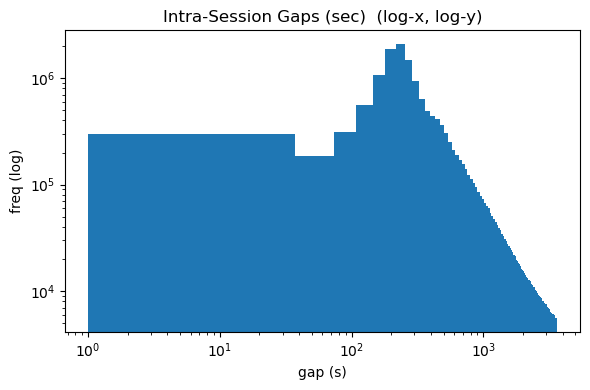

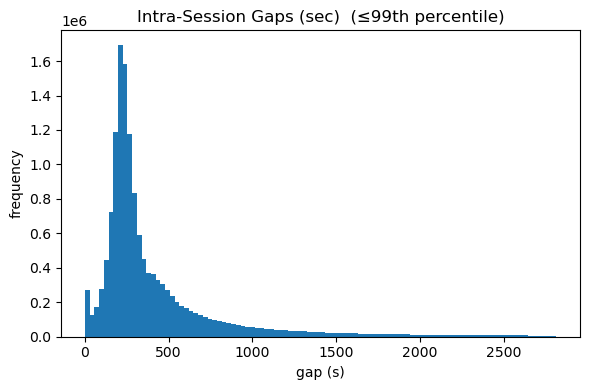

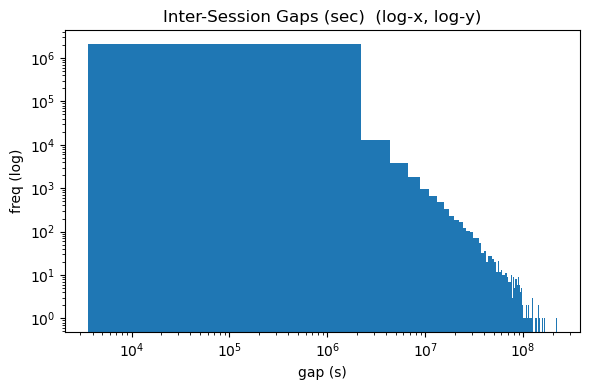

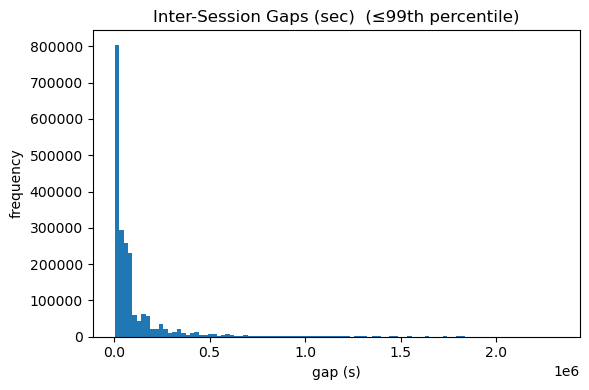

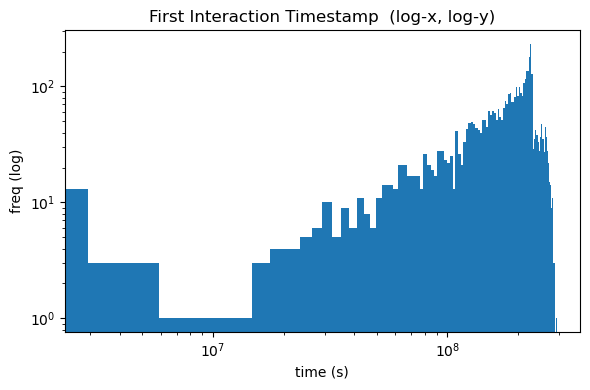

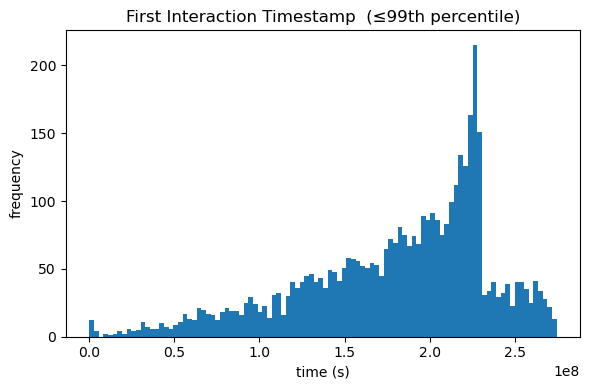

In [6]:
analyse_dataset('/home/jy1559/Mar2025_Module/Datasets/LFM-BeyMS/interactions_dense.json')


==== 사용자 요약 ====
total_users              : 93522
user_id_min              : 6
user_id_max              : 1407573
missing_user_ids         : 1314046

==== 아이템 요약 ====
item_id_min              : 1
item_id_max              : 100822
unique_items             : 100822
missing_item_ids         : 0

==== 분포별 기본 통계 ====

-- sessions_per_user --
  count    : 93522
  min      : 1.0
  max      : 213.0
  mean     : 3.140704860888347
  variance : 13.62902274048427

-- inters_per_user --
  count    : 93522
  min      : 1.0
  max      : 6643.0
  mean     : 8.524411368448066
  variance : 1913.3163188217302

-- session_lengths --
  count    : 293725
  min      : 1.0
  max      : 333.0
  mean     : 2.714171418844157
  variance : 46.78835053696164

-- inter_session_gaps --
  count    : 200203
  min      : 10800.0
  max      : 11661950.0
  mean     : 879399.4695534033
  variance : 2497789061170.0757

-- intra_session_gaps --
  count    : 503495
  min      : 0.0
  max      : 29660.0
  mean     : 600.58408

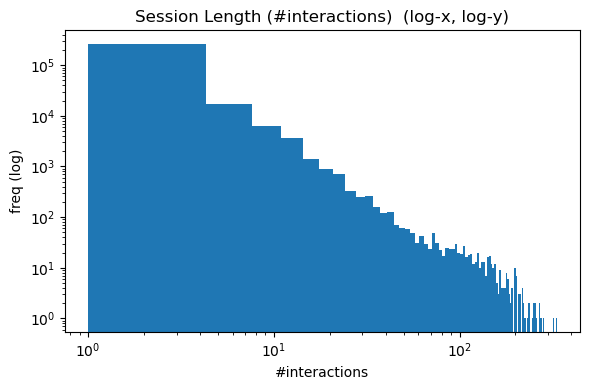

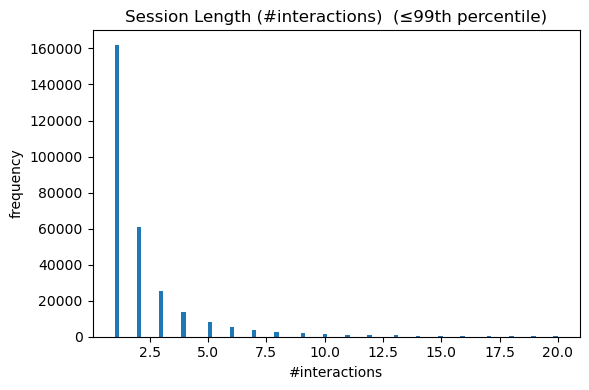

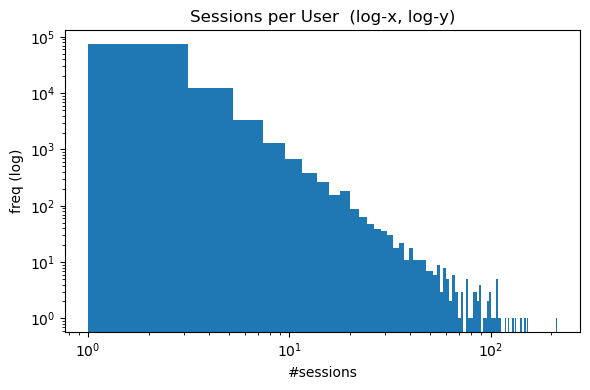

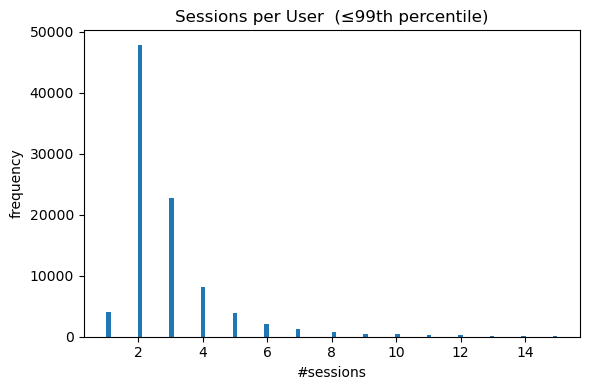

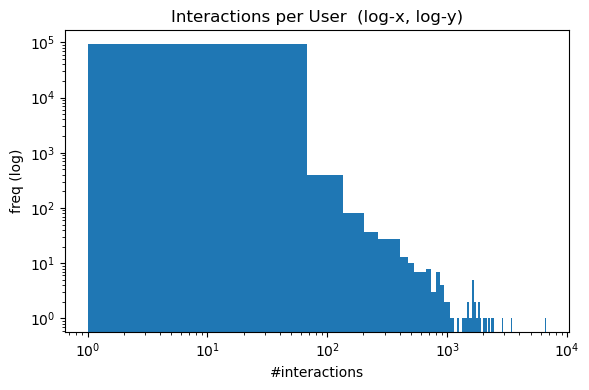

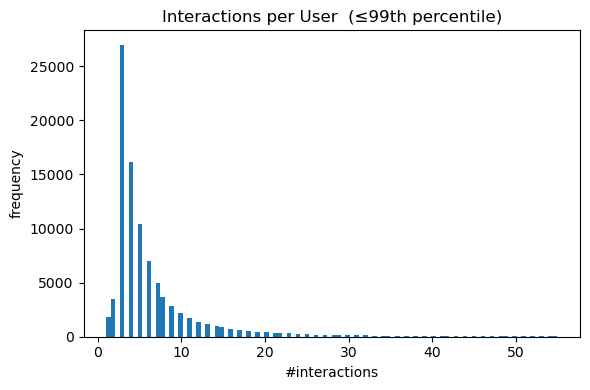

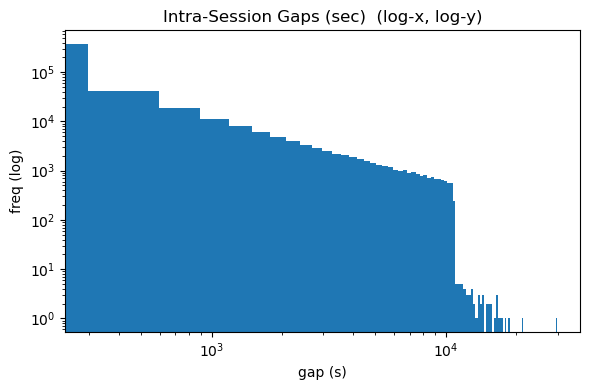

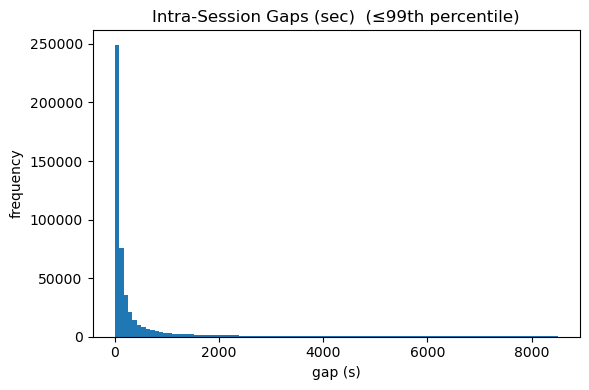

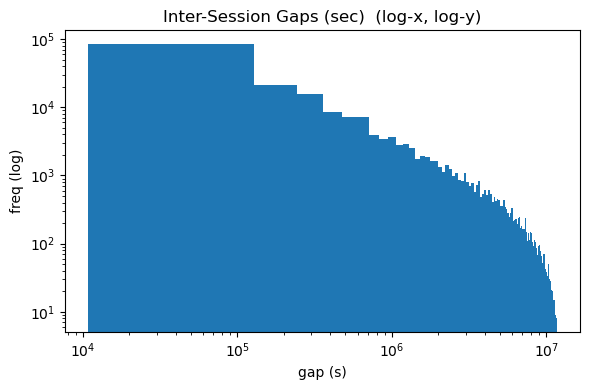

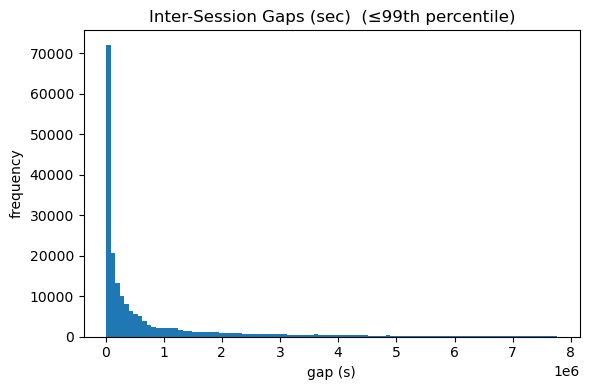

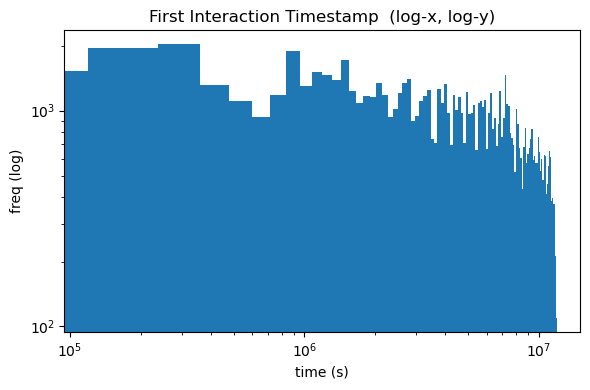

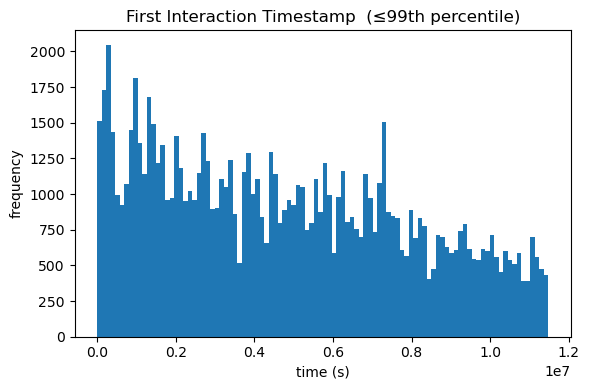

In [7]:
analyse_dataset('/home/jy1559/Mar2025_Module/Datasets/Retail_Rocket/interactions_dense.json')

In [ ]:
import pickle
path = '/home/jy1559/Mar2025_Module/Datasets/Globo/articles_embeddings_dense.pickle'
with open(path, 'rb') as f:
    articles_embeddings = pickle.load(f)
print(f"Articles embeddings shape: {articles_embeddings.shape}")
print(articles_embeddings[-2:])

Articles embeddings shape: (364047, 250)
[[ 0.22434181 -0.92328775 -0.38174152  0.6878903  -0.773911   -0.1036289
  -0.40648642  0.24600428  0.25519058 -0.32958737 -0.10673302 -0.32123068
  -0.6195845  -0.23177701 -0.15317842 -0.5247347   0.08937248 -0.09578277
  -0.40418136  0.41243804  0.25232828 -0.4696258   0.06727203  0.03161697
   0.14581785 -0.6898249   0.29183894  0.25440452 -0.43643528  0.43219405
   0.08636213 -0.12033444  0.5782993  -0.64203084  0.4230182   0.59376055
  -0.4289187   0.01825024 -0.44187546 -0.48158473 -0.59824085  0.22307885
   0.28990552 -0.90807617 -0.33124578 -0.10701723  0.6699629   0.325031
   0.44763875 -0.0881905  -0.46208882 -0.5463061   0.57854843 -0.3485703
  -0.08599228  0.00634613 -0.23032804  0.13713245  0.86666316  0.63482404
   0.69943845  0.7477148  -0.59326524 -0.7327466  -0.11202282  0.41898054
  -0.17338823 -0.28388792  0.17157124 -0.5759033   0.15346074 -0.2766681
   0.142611    0.65926874 -0.21911071  0.43663597 -0.36971065  0.29504687
  